In [57]:
# ------------------------------------------------------------
#  Generic BCH “sandwich”  e^{-S} H e^{S}  up to given order
#  order = 2  → keep terms through ½[[H,-S],-S]  (2nd-order SW)
#  order = 4  → keep terms through 1/6[[[[H,-S],-S],-S],-S]
# ------------------------------------------------------------
function sw_bch(H::Operator, S::Operator; order::Int=2)
    order ∈ (2,4) || error("order must be 2 or 4")

    minusS   = -S                                # e^{-S} ⋯ e^{S}
    Heff     = deepcopy(H)                       # H (0-th term)
    comm_k   = comm(H, minusS)                   # 1-st nested commutator
    Heff    += comm_k                           #   + [H,-S]

    # 2nd-order term  ½[[H,-S],-S]
    comm_k   = comm(comm_k, minusS)
    Heff    += 0.5 .* comm_k                    # multiply element-wise

    if order == 4
        # 3rd-order term  1/6[[[H,-S],-S],-S]
        comm_k   = comm(comm_k, minusS)         # one more nest
        Heff    += (1/6) .* comm_k
    end

    return Heff
end


sw_bch (generic function with 1 method)

In [84]:
# ============================================================
#  Schrieffer–Wolff‑based qubit–cavity simulator pipeline
#  -------------------------------------------------------
#  Julia + QuantumOptics.jl rewrite (QuantumOptics ≥ 1.0)
#  -------------------------------------------------------
#  1.  Build bare Duffing‑transmon + cavity Hamiltonian
#  2.  Run SW transform  → dressed (dispersive) parameters
#  3.  Find π‑pulse in 3‑level manifold (time‑dependent drive)
#  4.  Measurement pulse & expect ⟨I(t)⟩, ⟨Q(t)⟩ traces
#  5.  (stub) Add coloured phase‑noise & IQ clouds
# ============================================================

using QuantumOptics            # core library
using QuantumOptics: TimeDependentSum
using LinearAlgebra            # Diagonal, diag, eigen, …
using FFTW, Random             # extras
using Plots                    # quick‑look plotting

# ──────────────────────────────────────────────────────────────
# 0.  Global constants & helper utilities
# ──────────────────────────────────────────────────────────────
const PI2 = 2π

"""Simple 3 ns linear‑rise → flat‑top envelope."""
flat_top(t; rise_ns=3.0, amp=1.0) = amp * (t < rise_ns ? t / rise_ns : 1.0)

# ──────────────────────────────────────────────────────────────
# 1.  Bases, bare Hamiltonian & parameters (lab frame)
# ──────────────────────────────────────────────────────────────
Nq, Nc = 3, 5                             # transmon levels, cavity photons max

b_q_basis = FockBasis(Nq)                 # transmon basis
b_r_basis = FockBasis(Nc)                 # cavity basis
id_q = identityoperator(b_q_basis)
id_r = identityoperator(b_r_basis)

# Ladder & number operators
b_q, n_q = destroy(b_q_basis), number(b_q_basis)
a_r, n_r = destroy(b_r_basis), number(b_r_basis)

# Physical parameters [rad ns⁻¹]
ω_q = PI2*4.5           # bare qubit frequency
ω_r = PI2*7.0           # bare cavity frequency
α   = -PI2*0.3          # transmon anharmonicity
g   = PI2*0.100         # coupling strength
κ   = PI2*2e-3          # cavity κ

# Hamiltonian pieces
H_q   = ω_q*n_q + 0.5*α*n_q*(n_q - id_q)                         # Duffing
H_r   = ω_r*n_r                                                  # cavity
H_int = g*(tensor(b_q, dagger(a_r)) + tensor(dagger(b_q), a_r))  # J‑C

H_bare = tensor(H_q, id_r) + tensor(id_q, H_r) + H_int

# ──────────────────────────────────────────────────────────────
# 2.  Second‑order Schrieffer–Wolff transform (dispersive frame)
# ──────────────────────────────────────────────────────────────
comm(A,B) = A*B - B*A

H0 = Diagonal(diag(H_bare.data)) |> (x->Operator(basis(H_bare), x))
H1 = H_bare - H0

λ, ψ = eigenstates(dense(H0))

function build_S(λ, ψ, H1)
    dim = length(λ)
    Smat = zeros(ComplexF64, dim, dim)
    for m in 1:dim, n in 1:dim
        m == n && continue
        Smn = dagger(ψ[m]) * H1 * ψ[n]
        Smat[m,n] = Smn / (λ[m] - λ[n])
    end
    return Operator(basis(H1), Smat)
end

S_op  = build_S(λ, ψ, H1)
# H_eff = H0 + 0.5*comm(S_op, H1)

# # 4th-order SW
H_eff = sw_bch(H_bare, S_op; order=2)


# ──────────────────────────────────────────────────────────────
# 3.  π‑pulse search (full qubit ⊗ cavity space)
# ──────────────────────────────────────────────────────────────
# Drive only the qubit ladder but evolve in the complete Hilbert space so
# photon sectors don’t accidentally decouple.

# Initial state |0⟩_q ⊗ |0⟩_c
ψ_q0   = fockstate(b_q_basis, 0)
ψ_cav0 = fockstate(b_r_basis, 0)
ψ0_full = tensor(ψ_q0, ψ_cav0)

# Qubit‑only drive operator promoted to full space
Σx_full = tensor(b_q + dagger(b_q), id_r)

ωd = ω_q                                 # drive frequency (rad/ns)
H_rot_full = H_eff - ωd*tensor(n_q, id_r)  # rotating frame wrt qubit

Ω_R  = PI2*0.05                          # Rabi amplitude
Ω_env(t) = 0.5*Ω_R*flat_top(t)           # pulse envelope
H_td_full(t, _) = H_rot_full + Ω_env(t)*Σx_full

τ = 0:0.05:100.0                         # ns grid

tout, ψt = timeevolution.schroedinger_dynamic(τ, ψ0_full, H_td_full)

# Projector onto |1⟩_q regardless of cavity photons
P1_op = tensor(projector(fockstate(b_q_basis,1)), id_r)
P1 = [real(expect(P1_op, ψ)) for ψ in ψt]
π_idx = argmax(P1); t_π = τ[π_idx]; P1max = P1[π_idx]
twoπ_idx = argmin(P1); t_twoπ = τ[twoπ_idx]; P1max = P1[twoπ_idx]
@info "π‑pulse ≈ $(round(t_π; digits=2)) ns (max P1=$(round(P1max; digits=3)))"
@info "2π‑pulse ≈ $(round(t_twoπ; digits=2)) ns (min P1=$(round(P1max; digits=3)))"

# ──────────────────────────────────────────────────────────────
# 4.  Measurement pulse in dispersive frame (outline)
# ──────────────────────────────────────────────────────────────
# Cavity operator dressed by SW (stay in full qubit✕cavity space)
a_sw = tensor(id_q, a_r) + comm(S_op, tensor(id_q, a_r))

ωm = ω_r                                          # LO ~ cavity pull
N_cav = dagger(a_sw)*a_sw
H_meas_rot = H_eff - ωm*(tensor(n_q, id_r) + N_cav)

# Time‑dependent measurement envelope
a_meas_amp = κ
meas_env(t) = (0.0 ≤ t ≤ 1000) ? a_meas_amp : 0.0

# Build a TimeDependentSum operator for the measurement drive
H_meas_td = H_meas_rot + TimeDependentSum(meas_env => (a_sw + dagger(a_sw)))

c_ops  = [√κ * a_sw]
τ_meas = 0.0:1.0:1000.0

# Use the post‑π state as measurement input
ψπ = ψt[π_idx]                     # qubit ~|1⟩ after π‑pulse
ψ2π = ψt[twoπ_idx]                     # qubit ~|1⟩ after 2π‑pulse
ρ0 = projector(ψπ)
ρ1 = projector(ψ2π)

τ_out0, ρt0 = timeevolution.master_dynamic(τ_meas, ρ0, H_meas_td, c_ops)
τ_out1, ρt1 = timeevolution.master_dynamic(τ_meas, ρ1, H_meas_td, c_ops)

I_op0 = a_sw + dagger(a_sw)
Q_op0 = -1im*(a_sw - dagger(a_sw))
I_t0  = real.(expect(I_op0, ρt0))
Q_t0  = real.(expect(Q_op0, ρt0))

I_op1 = a_sw + dagger(a_sw)
Q_op1 = -1im*(a_sw - dagger(a_sw))
I_t1  = real.(expect(I_op1, ρt1))
Q_t1  = real.(expect(Q_op1, ρt1))

# # ──────────────────────────────────────────────────────────────
# # 5.  Quick‑look plots
# # ──────────────────────────────────────────────────────────────
# # 5a. Time‑domain traces
# plot(τ_out, I_t; label="I(t)", xlabel="t [ns]", ylabel="Quadrature")
# plot!(τ_out, Q_t; label="Q(t)")



# # 5b. IQ phase‑space trajectory (parametric)
# plot(I_t, Q_t;
#      xlabel="I", ylabel="Q", label="IQ path", aspect_ratio=:equal)
# scatter!(I_t[[1, end]], Q_t[[1, end]];
#          label=["start" "end"], markersize=5)

# println("Measurement trajectory simulated; real‑valued I/Q arrays ready.")


┌ Info: π‑pulse ≈ 92.4 ns (max P1=0.0)
└ @ Main /Users/mirko/Workspace/superconducting-qubits/numerics/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:113
┌ Info: 2π‑pulse ≈ 0.0 ns (min P1=0.0)
└ @ Main /Users/mirko/Workspace/superconducting-qubits/numerics/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:114


1001-element Vector{Float64}:
  0.0
 -0.02244992538867757
 -0.03469740376949461
 -0.03145245971081615
 -0.014291331001471643
  0.008892438147196782
  0.02765411203086667
  0.03370435561068697
  0.02441380911982209
  0.004206906736867964
  ⋮
 -0.00035755165214722967
 -0.0003498316547983303
 -0.0004229496265081549
 -0.00035817399016913634
 -0.0003711974585813963
 -0.00027028226840442856
 -0.0002868614640282817
 -0.0002272051863191325
 -0.00030382542519703326

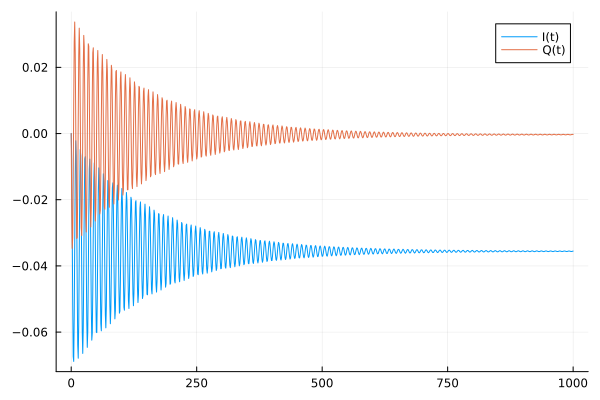

In [85]:
using Plots; 
plot(τ_out, I_t1; label="I(t)"); 
plot!(τ_out, Q_t1; label="Q(t)")


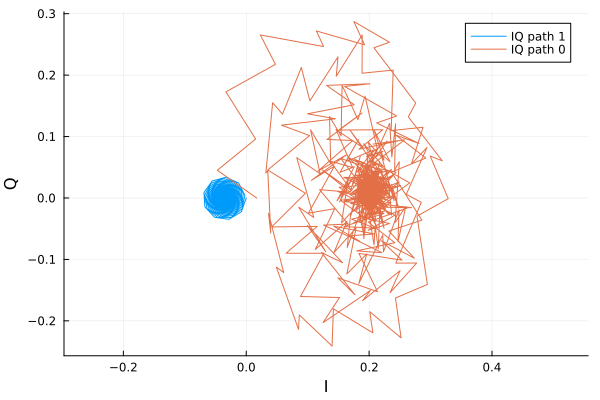

In [86]:
plot(I_t1, Q_t1;
     xlabel="I", ylabel="Q", label="IQ path 1", aspect_ratio=:equal)
# scatter!(I_t1[[1, end]], Q_t1[[1, end]];
#          label=["start" "end"], markersize=5)

plot!(I_t0, Q_t0;
         xlabel="I", ylabel="Q", label="IQ path 0", aspect_ratio=:equal)
#     scatter!(I_t0[[1, end]], Q_t0[[1, end]];
#              label=["start" "end"], markersize=5)